Data source:
Kaggle. (2012). Titanic: Machine Learning from Disaster. Retrieved from https://www.kaggle.com/c/titanic/data.

In this tutorial, we will walk through the process of getting a local and global feature-based explanation for model predictions on the Titanic dataset. We will see which features contribute most to survival predictions for passengers who were on board the Titanic.


In [22]:
import pandas as pd
import numpy as np

np.random.seed(123)

We will begin by loading the data, and writing out human-readable descriptions of all features.

In [23]:
from sklearn.model_selection import train_test_split
from pyreal.applications import titanic

np.random.seed(1)

x_orig, y = titanic.load_titanic_data()

x_train_orig, x_test_orig, y_train, y_test = train_test_split(x_orig, y, test_size=.20)

print("Features:", x_orig.columns.values)

feature_descriptions = {
    "PassengerId": "Passenger ID",
    "Pclass": "Ticket Class",
    "SibSp": "Number of siblings/spouses aboard",
    "Parch": "Number of parents/children aboard",
    "Ticket": "Ticket Number",
    "Fare": "Passenger Fare",
    "Cabin": "Cabin Number",
    "Embarked": "Port of Embarkment",
}

Features: ['PassengerId' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Ticket' 'Fare'
 'Cabin' 'Embarked']


Next, we will make the transformers. `Pyreal`'s built-in transformers all have explanation transforms, which bring explanations from the model form to the interpretable form.

In [24]:
from pyreal.transformers import OneHotEncoder, ColumnDropTransformer, MultiTypeImputer
from pyreal.transformers import fit_transformers, run_transformers

column_drop = ColumnDropTransformer(["PassengerId", "Name", "Ticket", "Cabin"])
imputer = MultiTypeImputer()
one_hot_encoder = OneHotEncoder(["Sex", "Embarked"])

transformers = [column_drop, imputer, one_hot_encoder]
fit_transformers(transformers, x_train_orig)
x_transform_train = run_transformers(transformers, x_train_orig)
x_transform_test = run_transformers(transformers, x_test_orig)

In [25]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=500)
model.fit(x_transform_train, y_train)

preds = model.predict(x_transform_test)
print("Test accuracy: %.2f" % (np.mean(preds==y_test)*100))

Test accuracy: 79.89


Now, we can make the explainer...

In [26]:
from pyreal.explainers import LocalFeatureContribution

lfc = LocalFeatureContribution(model=model, x_train_orig=x_train_orig, transformers=transformers,
                               feature_descriptions=feature_descriptions, fit_on_init=True)

... and visualize the explanation.

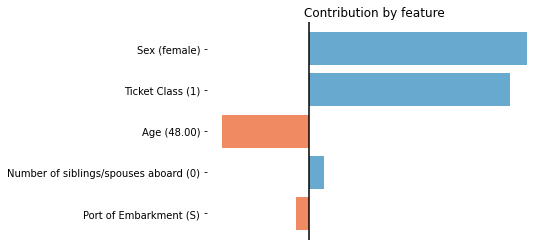

In [27]:
from pyreal.utils import visualize

input_to_explain = x_test_orig.iloc[0]
contributions = lfc.produce(input_to_explain)
x_interpret = lfc.convert_data_to_interpretable(input_to_explain)

visualize.plot_top_contributors(contributions, select_by="absolute",
                                values=x_interpret, show=True)

We can also generate a global feature explanation, that explains the overall importance of features.

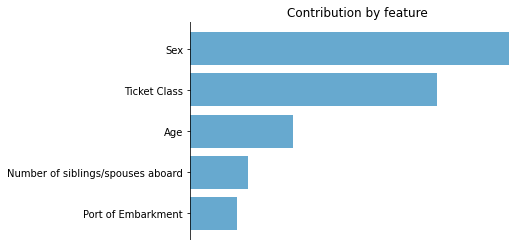

In [28]:
from pyreal.explainers import GlobalFeatureImportance

gfi = GlobalFeatureImportance(model=model, x_train_orig=x_train_orig,
                              transformers=transformers,
                              feature_descriptions=feature_descriptions, fit_on_init=True)

importances = gfi.produce()

visualize.plot_top_contributors(importances, select_by="absolute", show=True)